# Data Cleaning

## Outline
0. Load and join dataframes
1. Handle missing values
   - Identify columns with missing data
   - Decide on appropriate strategies for each column
   - Impute or handle missing values as needed
2. Convert data types
   - Change 'start_date' to datetime format
   - Convert 'home_line_scores' and 'away_line_scores' to usable format
3. Handle outliers
   - Check for and address unrealistic values in numerical columns
4. Create derived features
   - Calculate point difference
   - Generate 'winner' column
   - Create time-based features from 'start_date'
5. Review and validate cleaned dataset

## Load Packages & Data

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the project root to the Python path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.cleaning import (
    merge_and_clean_dataframes,
    clean_dataframe,
    generate_and_save_team_pairs,
    deduplicate_dataframes
)
from src.visualization.distribution_plots import (
    analyze_distribution,
    visualize_null_values,
    plot_mean_over_time,
    plot_null_frequency_by_season,
    plot_zero_values_by_year
)

In [2]:
# Load the games data from the parquet file
games_df = pd.read_parquet('../data/01_raw/games.parquet')

# Load the advanced team game stats from the parquet file
advanced_stats_df = pd.read_parquet('../data/01_raw/advanced_team_game_stats.parquet')

# Load the team game stats from the parquet file
team_stats_df = pd.read_parquet('../data/01_raw/team_game_stats.parquet')

# Load the team talent data from the parquet file
team_talent_df = pd.read_parquet('../data/01_raw/team_talent.parquet')

## Null team_stats_df

In [144]:
# Filter games_df to include only rows where the id exists in team_stats_df
initial_count = len(games_df)
games_df = games_df[games_df['id'].isin(team_stats_df['id'])]
filtered_count = len(games_df)

# Calculate the number and percentage of rows dropped
rows_dropped = initial_count - filtered_count
percentage_dropped = (rows_dropped / initial_count) * 100

print(f"Rows dropped: {rows_dropped}")
print(f"Percentage of rows dropped: {percentage_dropped:.2f}%")

Rows dropped: 1569
Percentage of rows dropped: 15.14%


## Drop Duplicates

In [145]:
# Use the function to deduplicate all dataframes at once
deduplicated_dfs, total_rows_dropped = deduplicate_dataframes(
    games_df, team_stats_df, team_talent_df,
    df_names=["games_df", "team_stats_df", "team_talent_df"]
)

# Unpack the deduplicated dataframes
games_df, team_stats_df, team_talent_df = deduplicated_dfs

games_df: Dropped 439 duplicate rows
team_stats_df: Dropped 878 duplicate rows
team_talent_df: Dropped 3 duplicate rows

Total duplicate rows dropped across all dataframes: 1320


## Join Data

In [146]:
# Use the function to merge and clean the dataframes
merged_df_final = merge_and_clean_dataframes(games_df, team_stats_df, advanced_stats_df, team_talent_df)

# Check the shape of the final dataframe
print("Shape of merged_df_final:", merged_df_final.shape)

df = merged_df_final.copy()

Shape of merged_df_final: (16708, 122)


## Check for Duplicates

In [147]:
# Check for duplicate 'id' and 'team' combinations
duplicate_id_team = df.duplicated(subset=['id', 'team'])
num_duplicates = duplicate_id_team.sum()
total_rows = len(df)
duplicate_percentage = (num_duplicates / total_rows) * 100

print(f"Number of duplicate 'id' and 'team' combinations: {num_duplicates}")
print(f"Percentage of duplicate 'id' and 'team' combinations: {duplicate_percentage:.2f}%")


Number of duplicate 'id' and 'team' combinations: 0
Percentage of duplicate 'id' and 'team' combinations: 0.00%


## Handle Missing Values

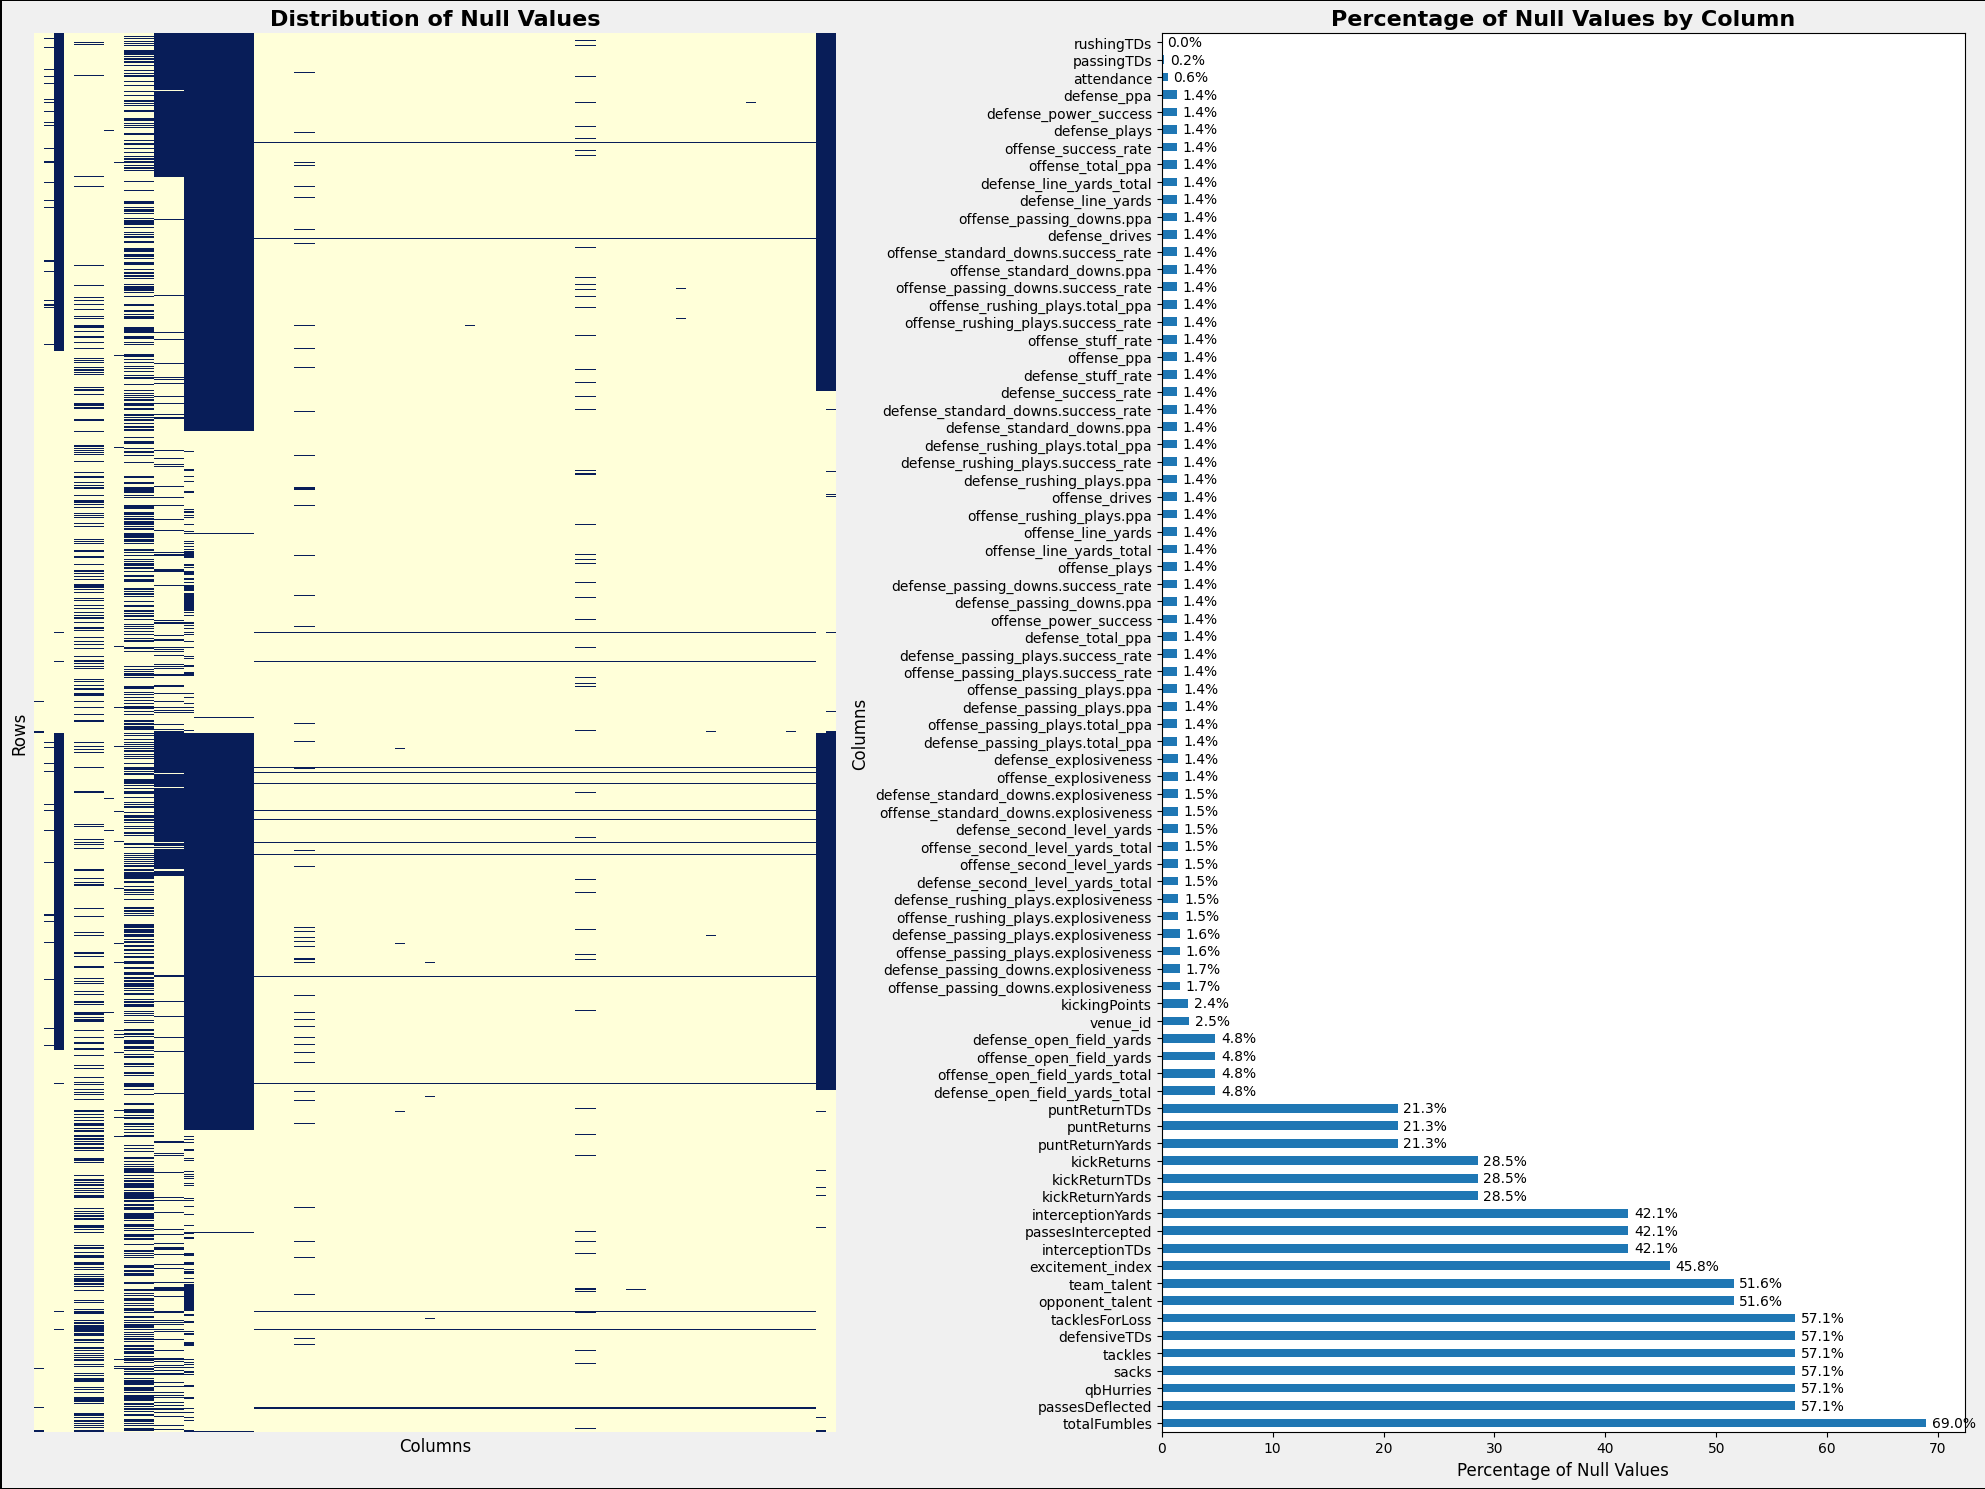

Columns with null values (sorted by percentage, descending):
totalFumbles: 11521 null values (68.95%)
passesDeflected: 9546 null values (57.13%)
qbHurries: 9546 null values (57.13%)
sacks: 9546 null values (57.13%)
tackles: 9546 null values (57.13%)
defensiveTDs: 9546 null values (57.13%)
tacklesForLoss: 9546 null values (57.13%)
opponent_talent: 8614 null values (51.56%)
team_talent: 8614 null values (51.56%)
excitement_index: 7654 null values (45.81%)
interceptionTDs: 7029 null values (42.07%)
passesIntercepted: 7029 null values (42.07%)
interceptionYards: 7029 null values (42.07%)
kickReturnYards: 4763 null values (28.51%)
kickReturnTDs: 4763 null values (28.51%)
kickReturns: 4763 null values (28.51%)
puntReturnYards: 3557 null values (21.29%)
puntReturns: 3557 null values (21.29%)
puntReturnTDs: 3557 null values (21.29%)
defense_open_field_yards_total: 808 null values (4.84%)
offense_open_field_yards_total: 808 null values (4.84%)
offense_open_field_yards: 808 null values (4.84%)
d

In [148]:
visualize_null_values(df)

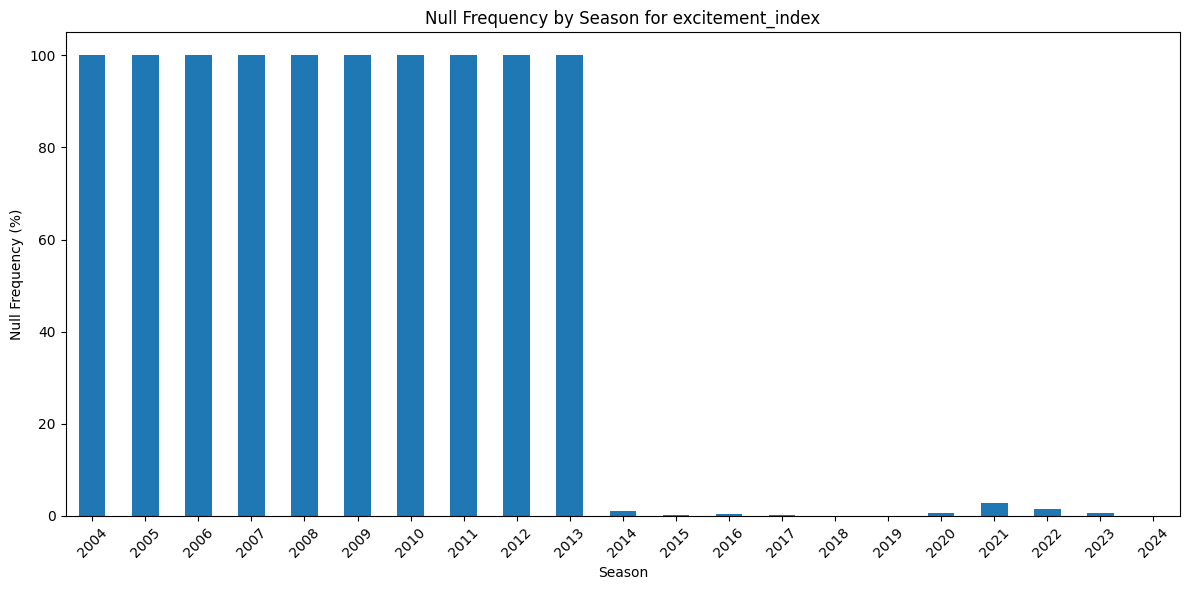

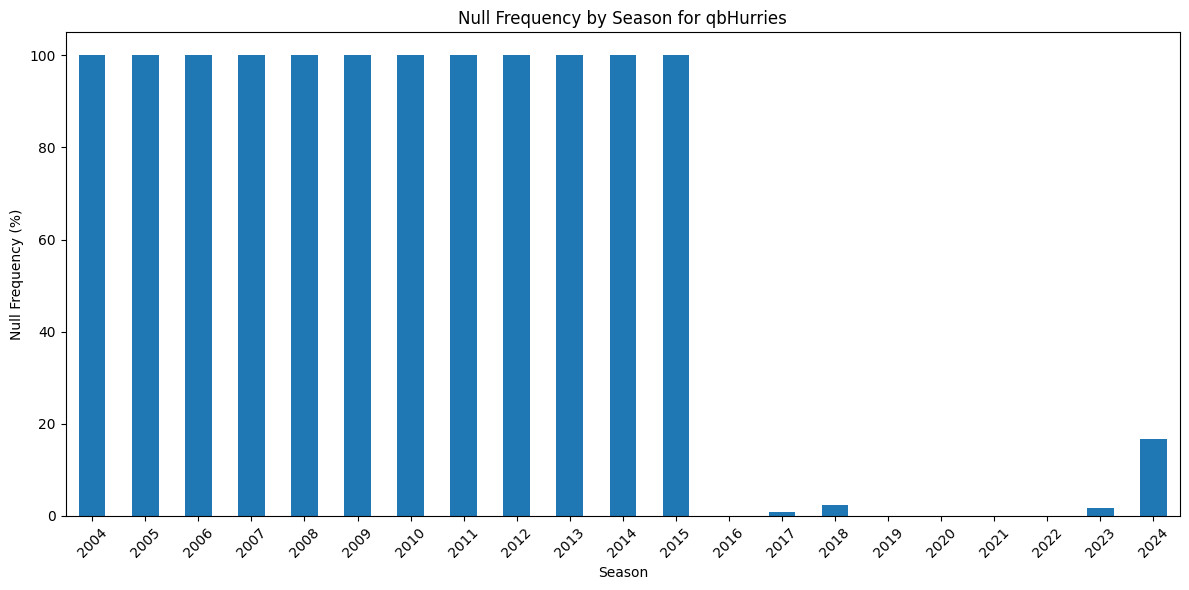

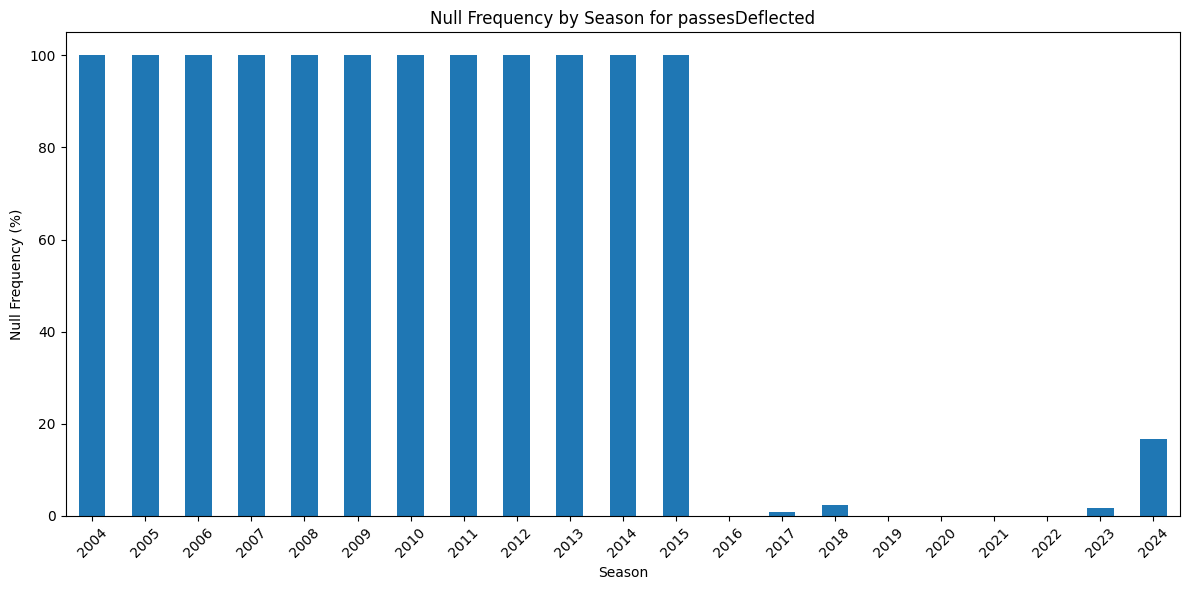

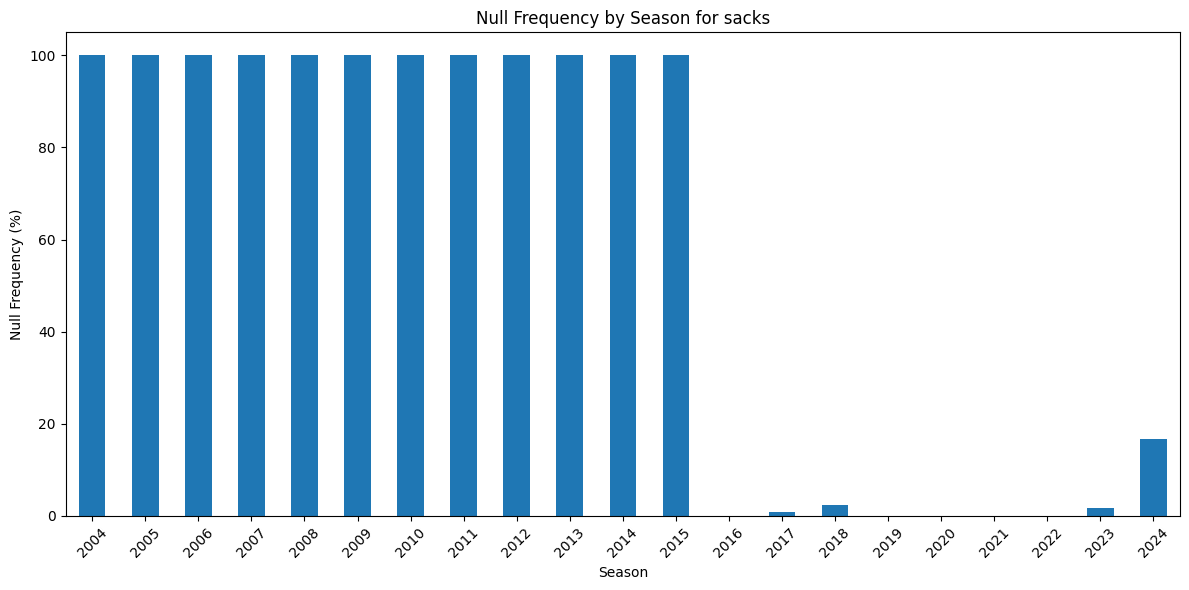

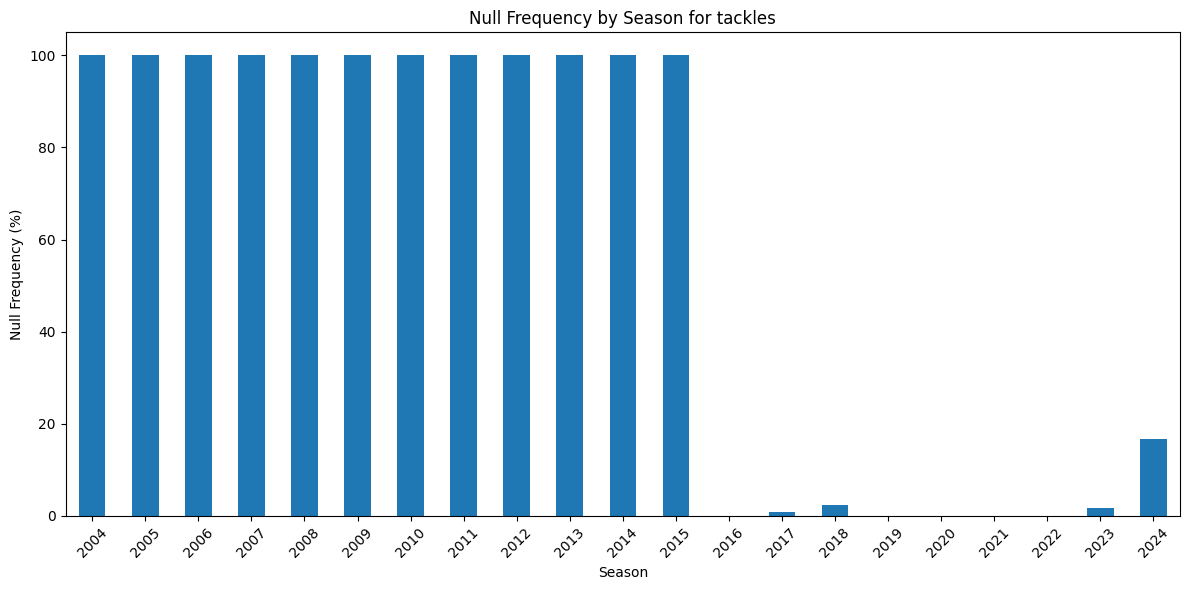

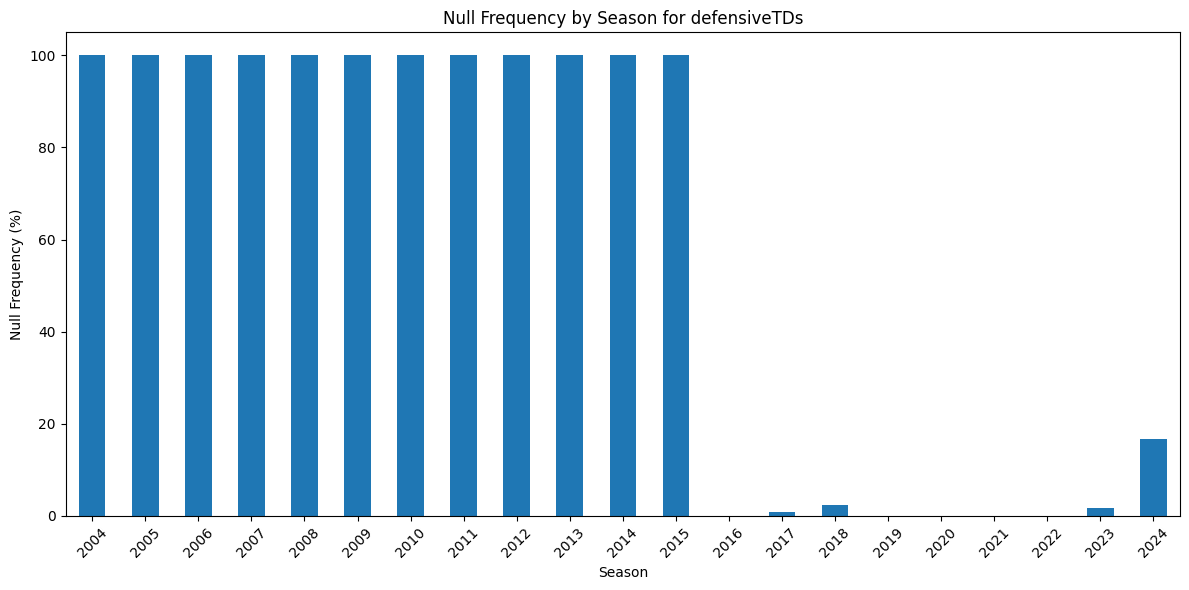

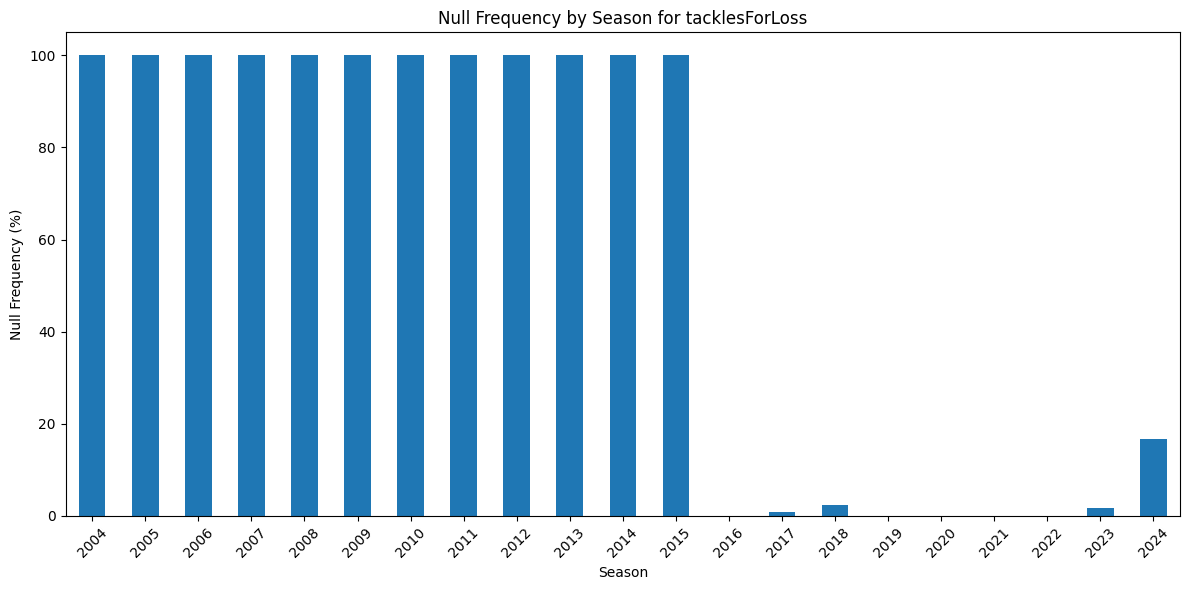

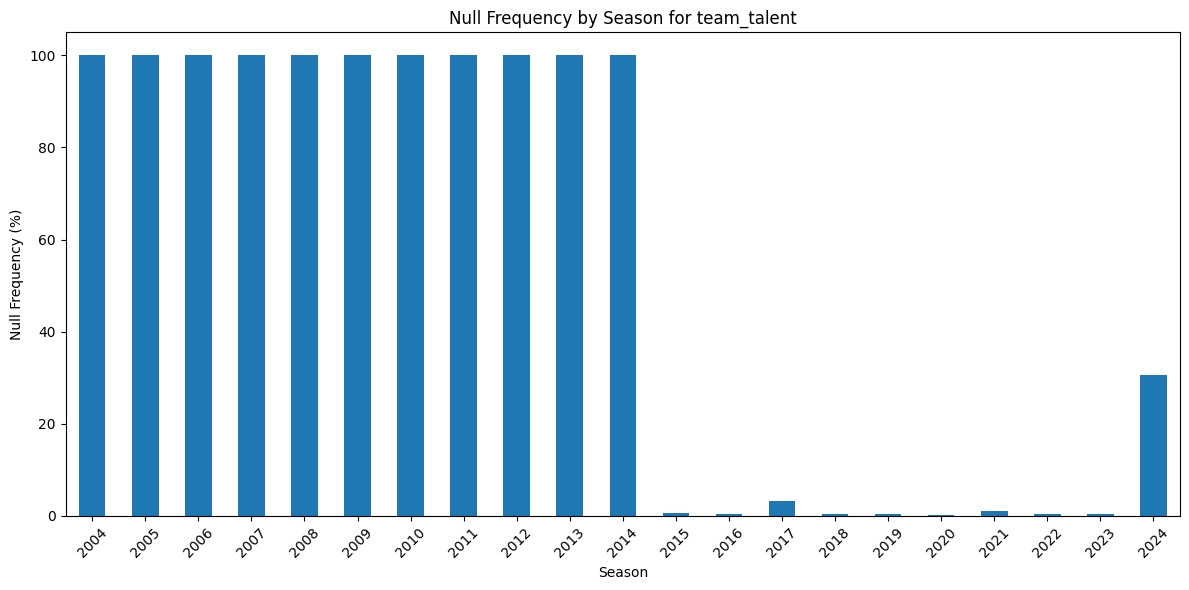

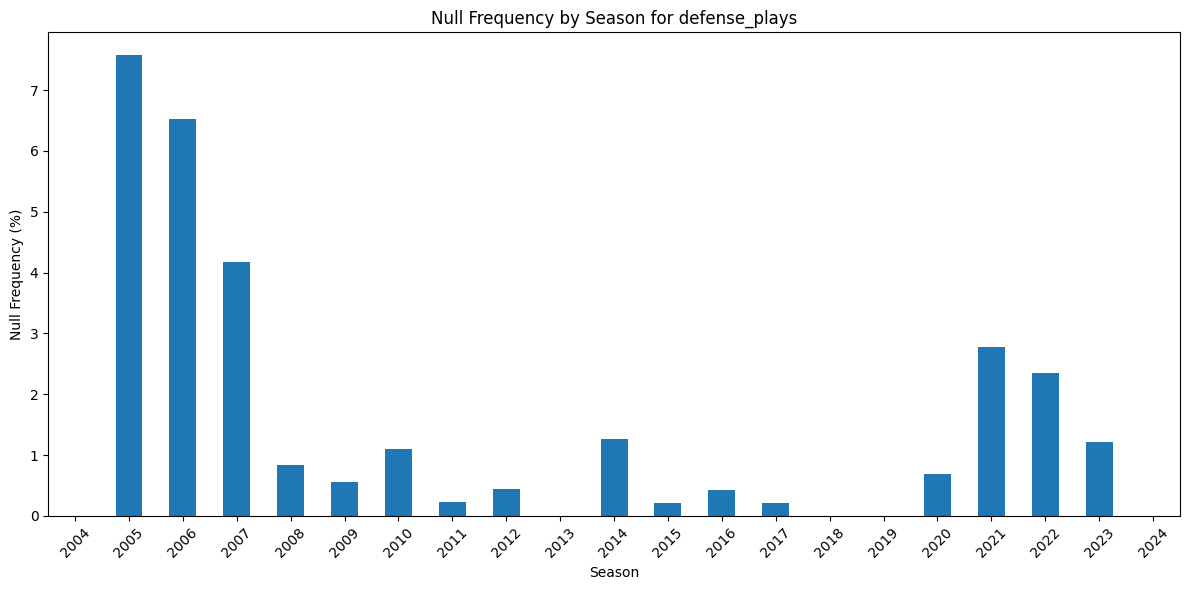

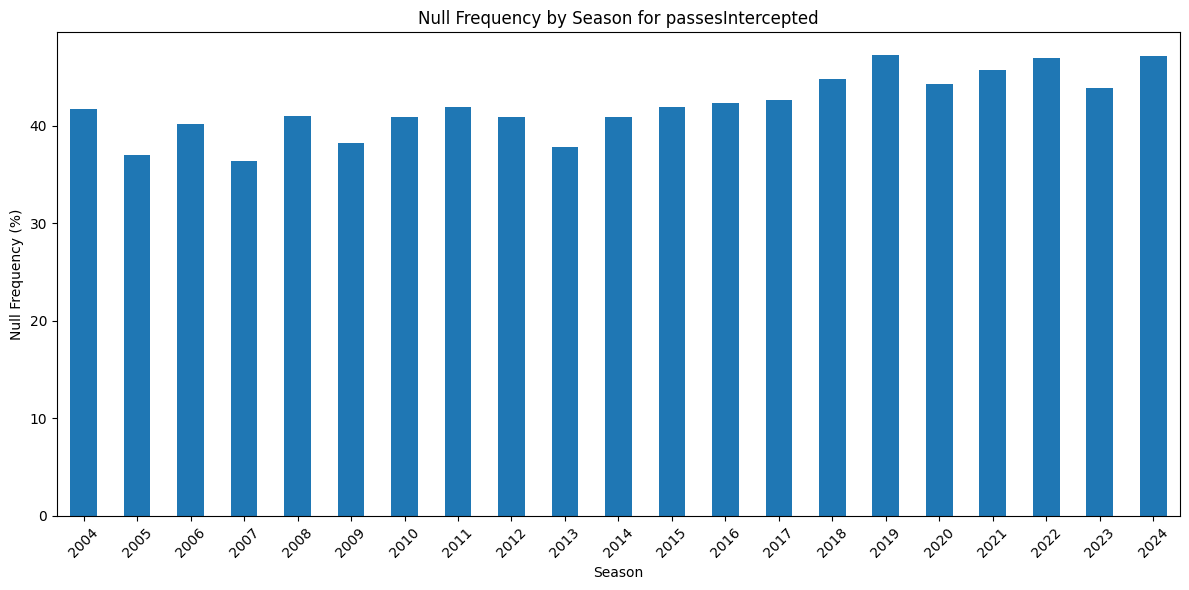

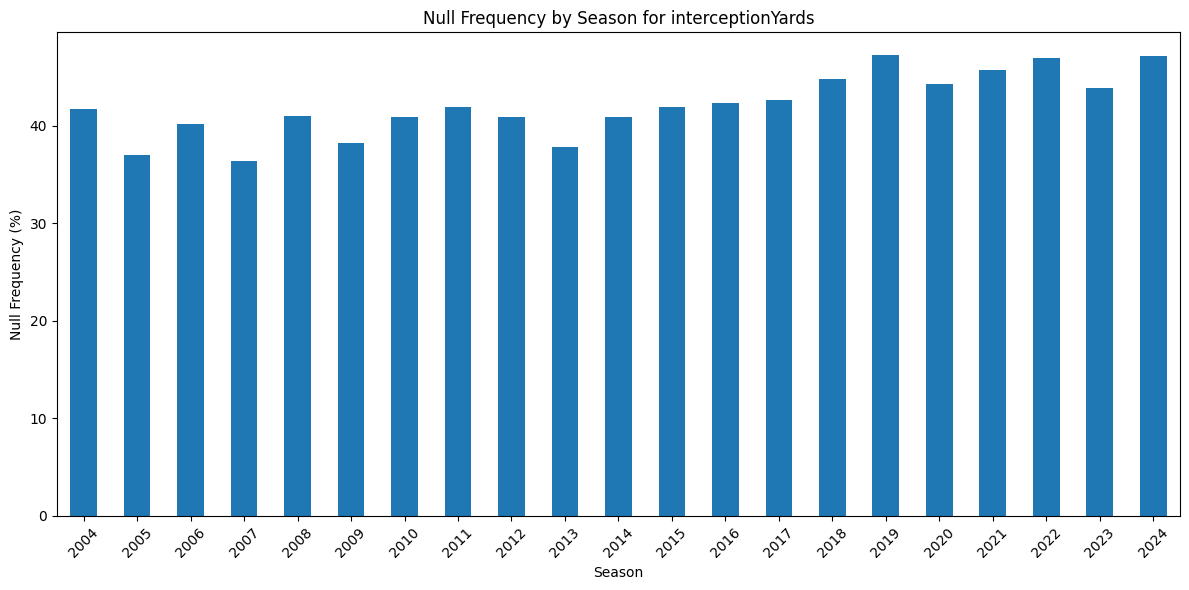

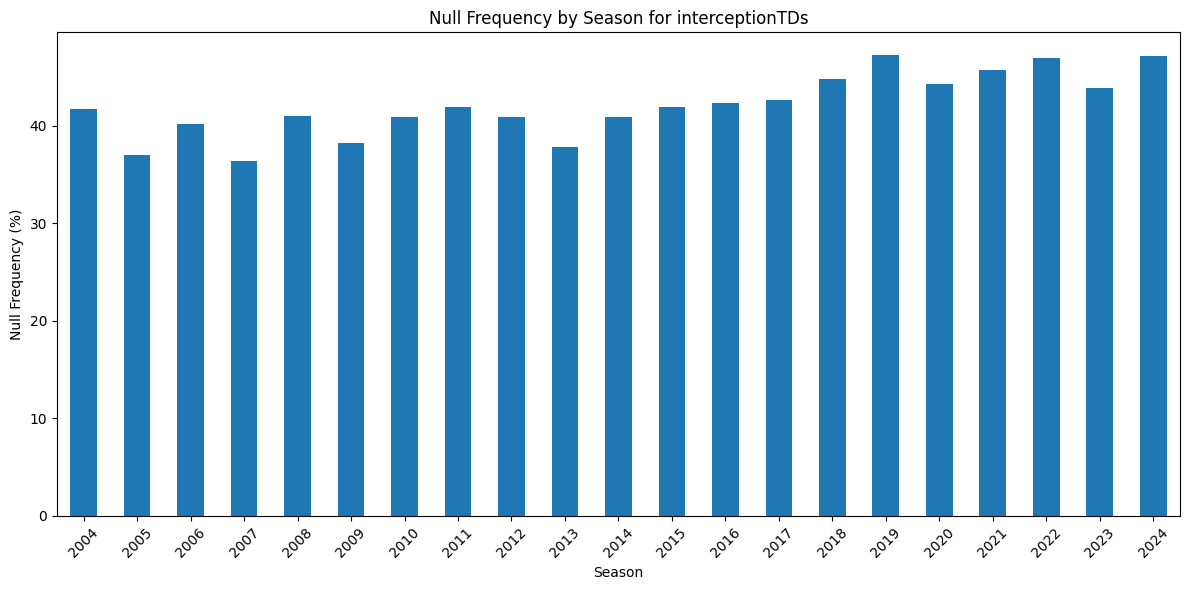

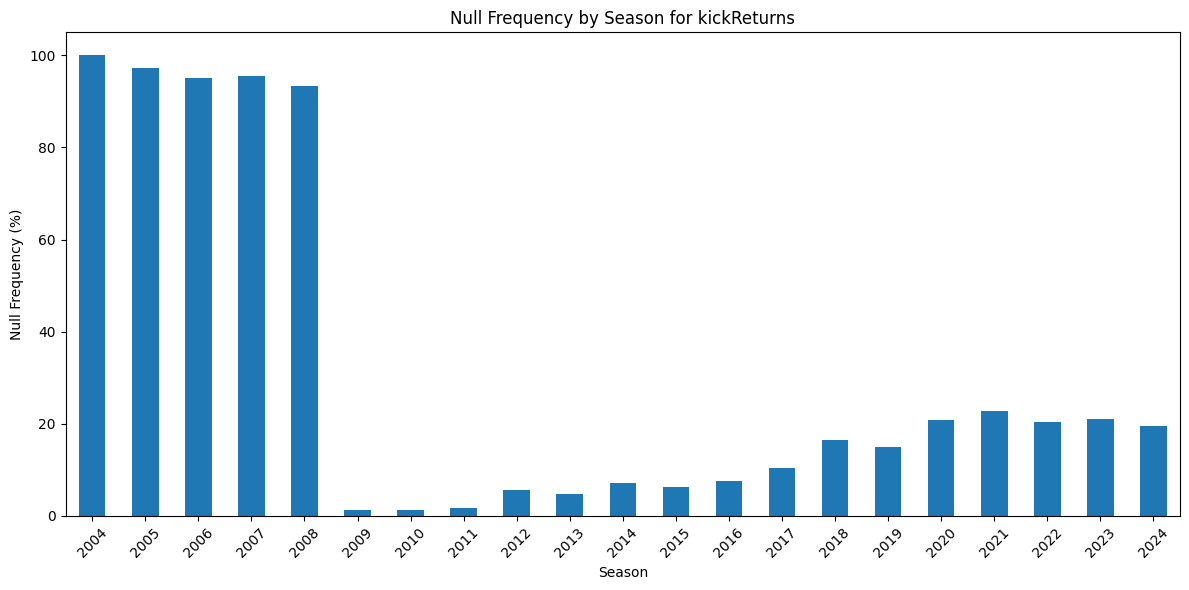

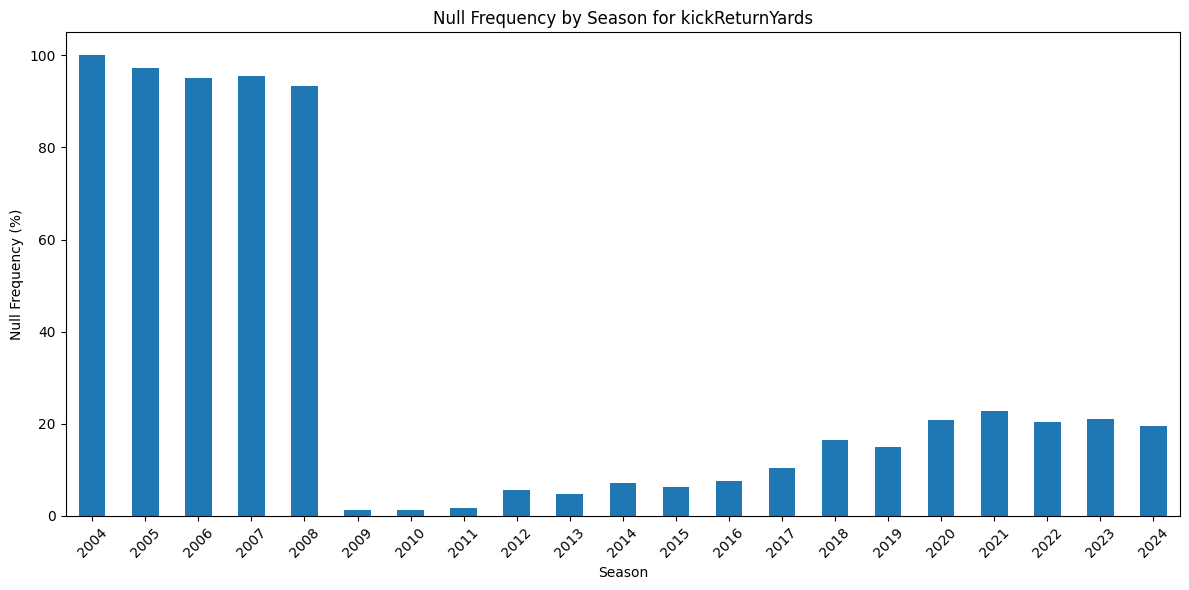

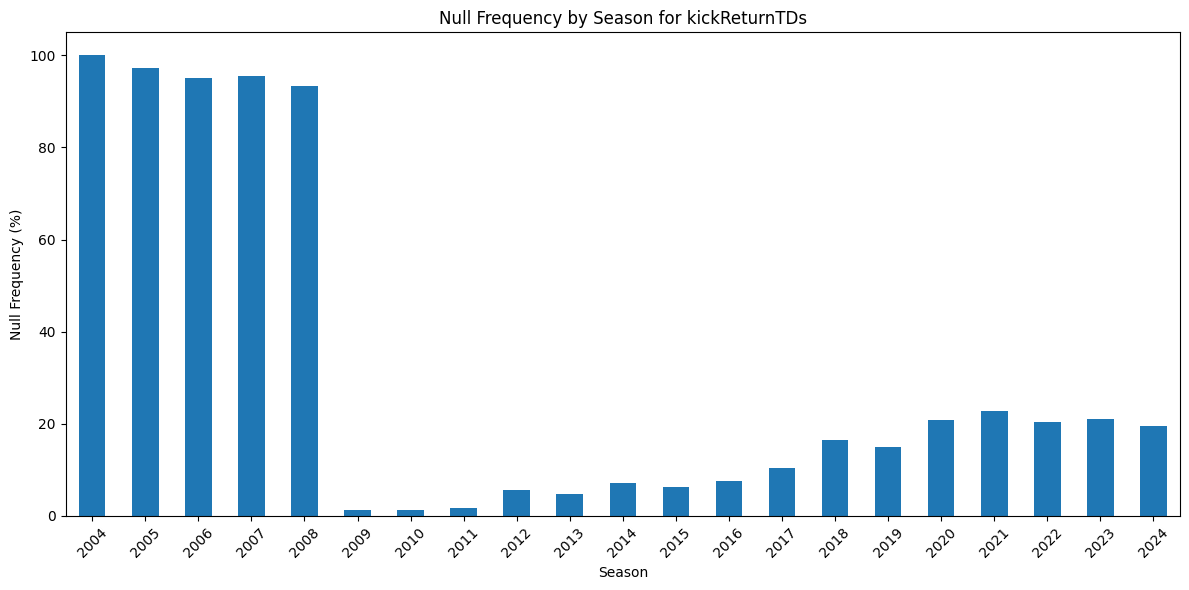

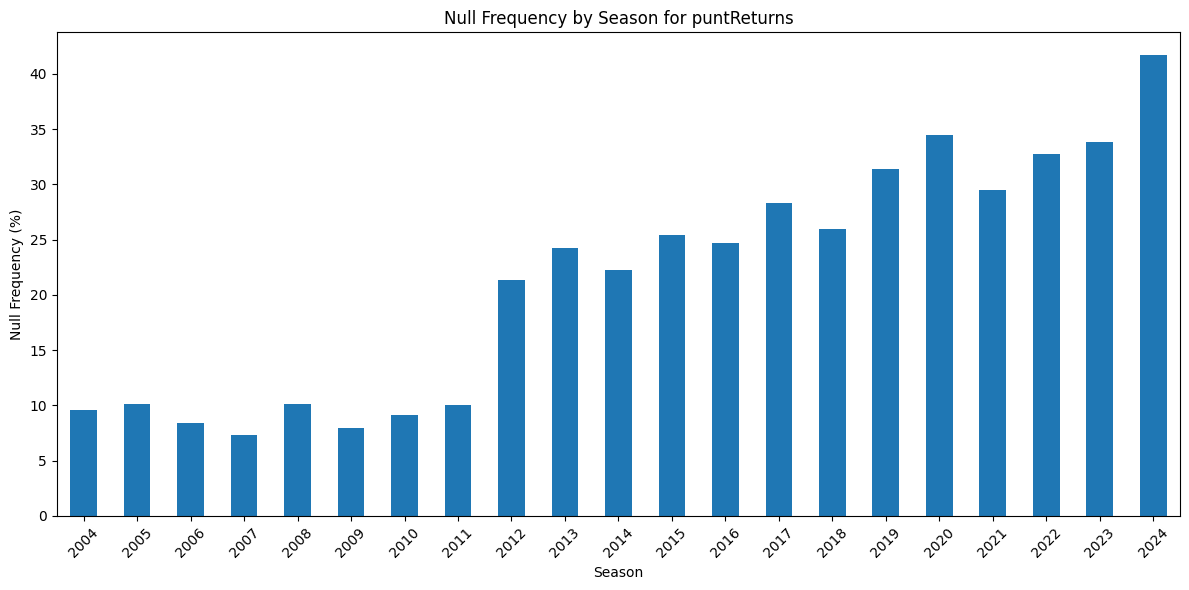

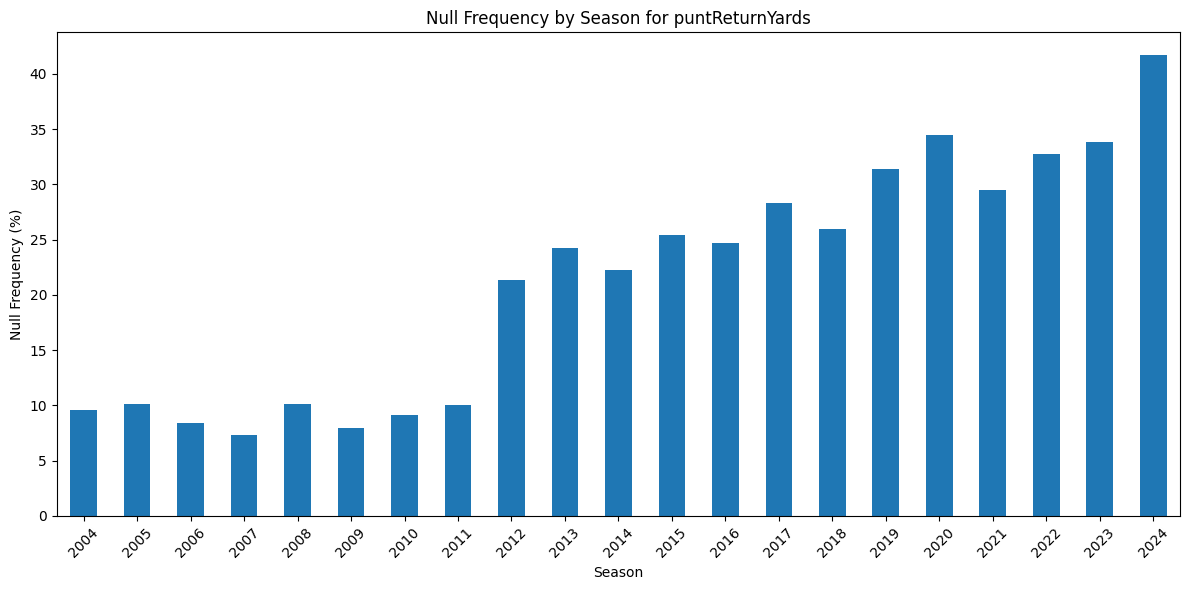

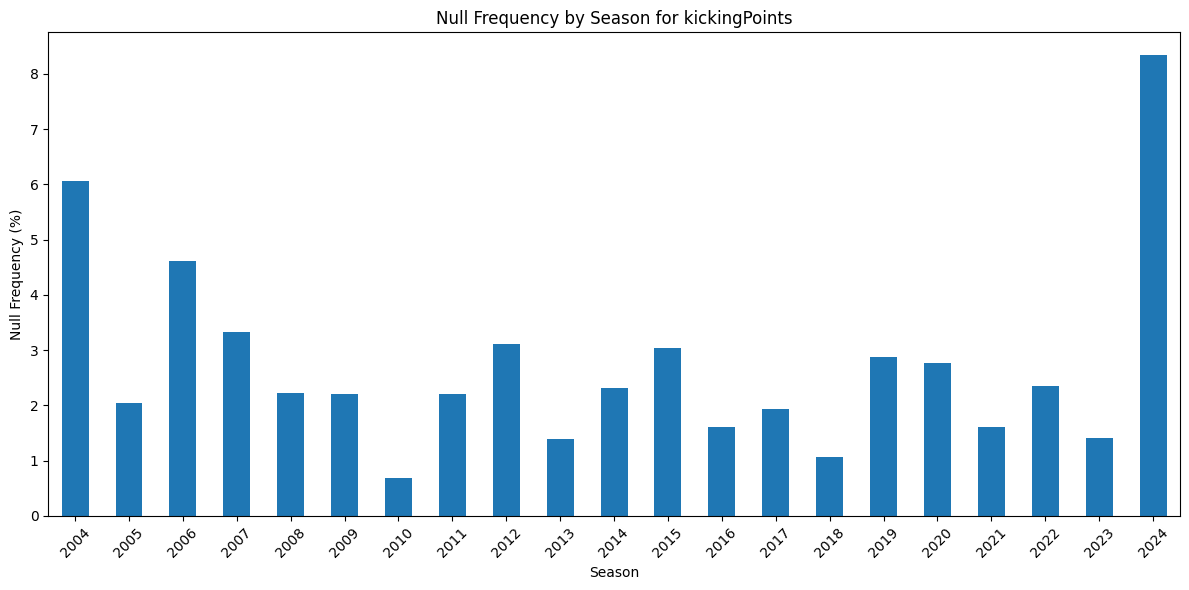

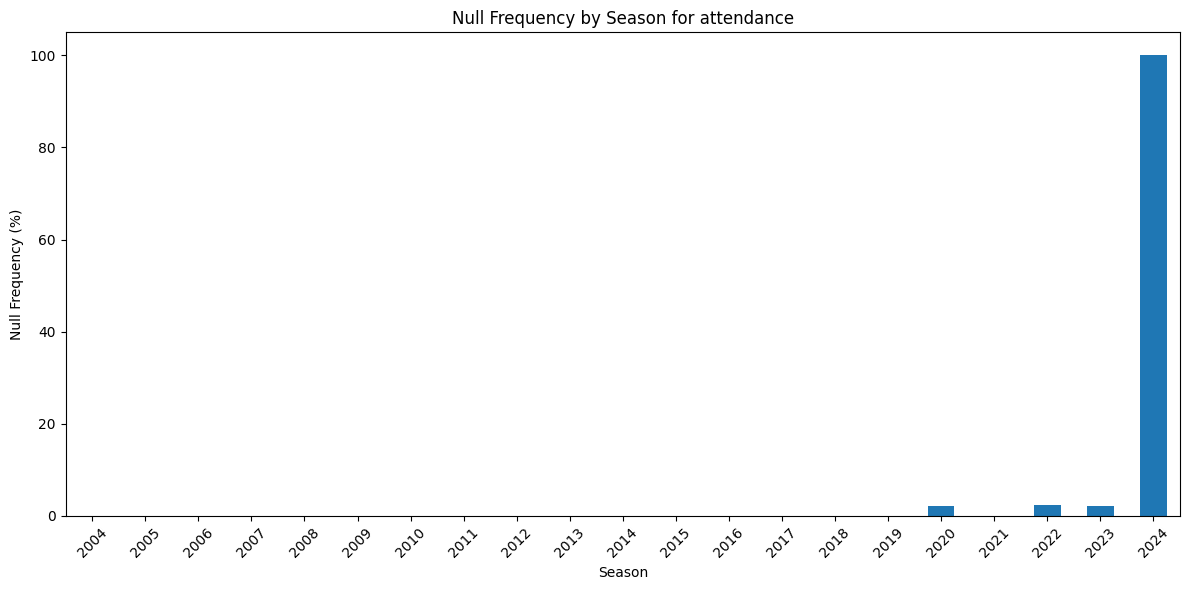

In [90]:
plot_null_frequency_by_season(df, [
    'excitement_index',
    'qbHurries',
    'passesDeflected',
    'sacks',
    'tackles',
    'defensiveTDs',
    'tacklesForLoss',
    'team_talent',
    'defense_plays',
    'passesIntercepted',
    'interceptionYards',
    'interceptionTDs',
    'kickReturns',
    'kickReturnYards',
    'kickReturnTDs',
    'puntReturns',
    'puntReturnYards',
    'kickingPoints',
    'attendance'
])

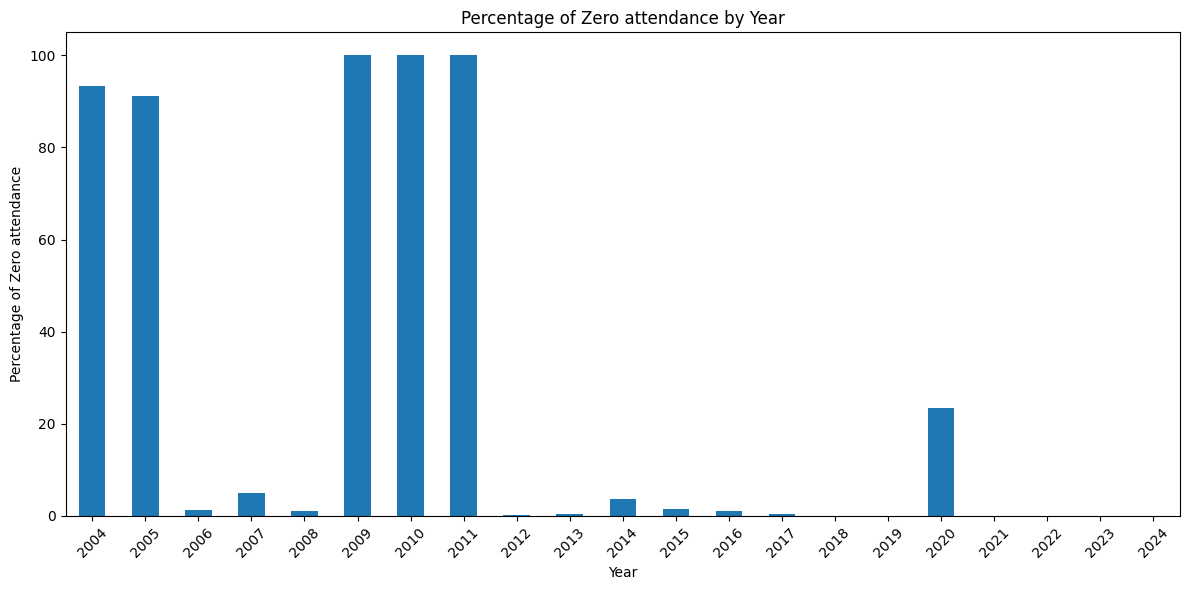

In [96]:
plot_zero_values_by_year(df, 'attendance')

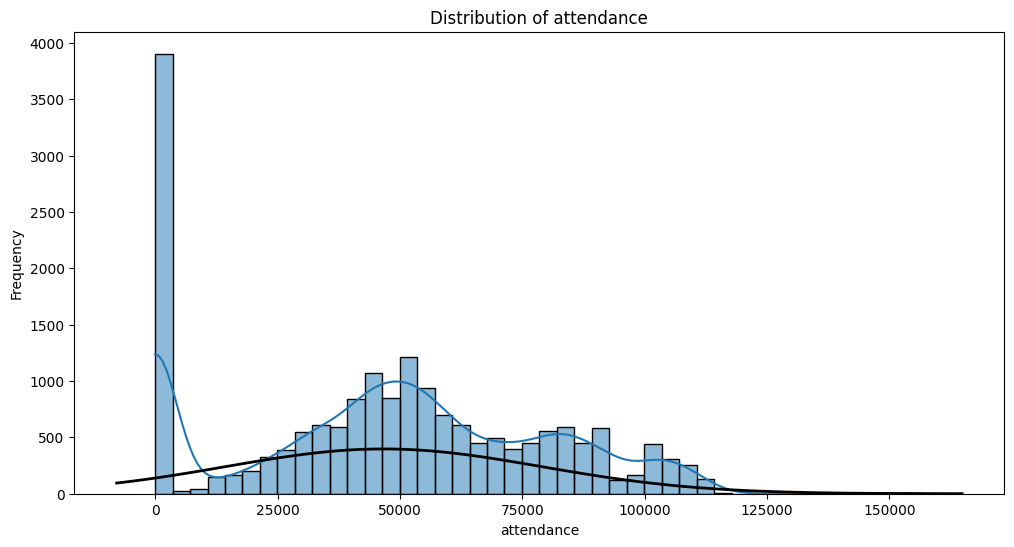

Shapiro-Wilk test - statistic: 0.9423, p-value: 0.0000
Skewness: 0.0227
Kurtosis: -0.9192


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 18564.
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
analyze_distribution(df, 'attendance')

In [169]:
# Apply the cleaning function
cleaned_df = clean_dataframe(df)

# Check how many rows were removed
print(f"Rows before cleaning: {len(df)}")
print(f"Rows after cleaning: {len(cleaned_df)}")
print(f"Rows removed: {len(df) - len(cleaned_df)}")

Rows before cleaning: 16708
Rows after cleaning: 16438
Rows removed: 270


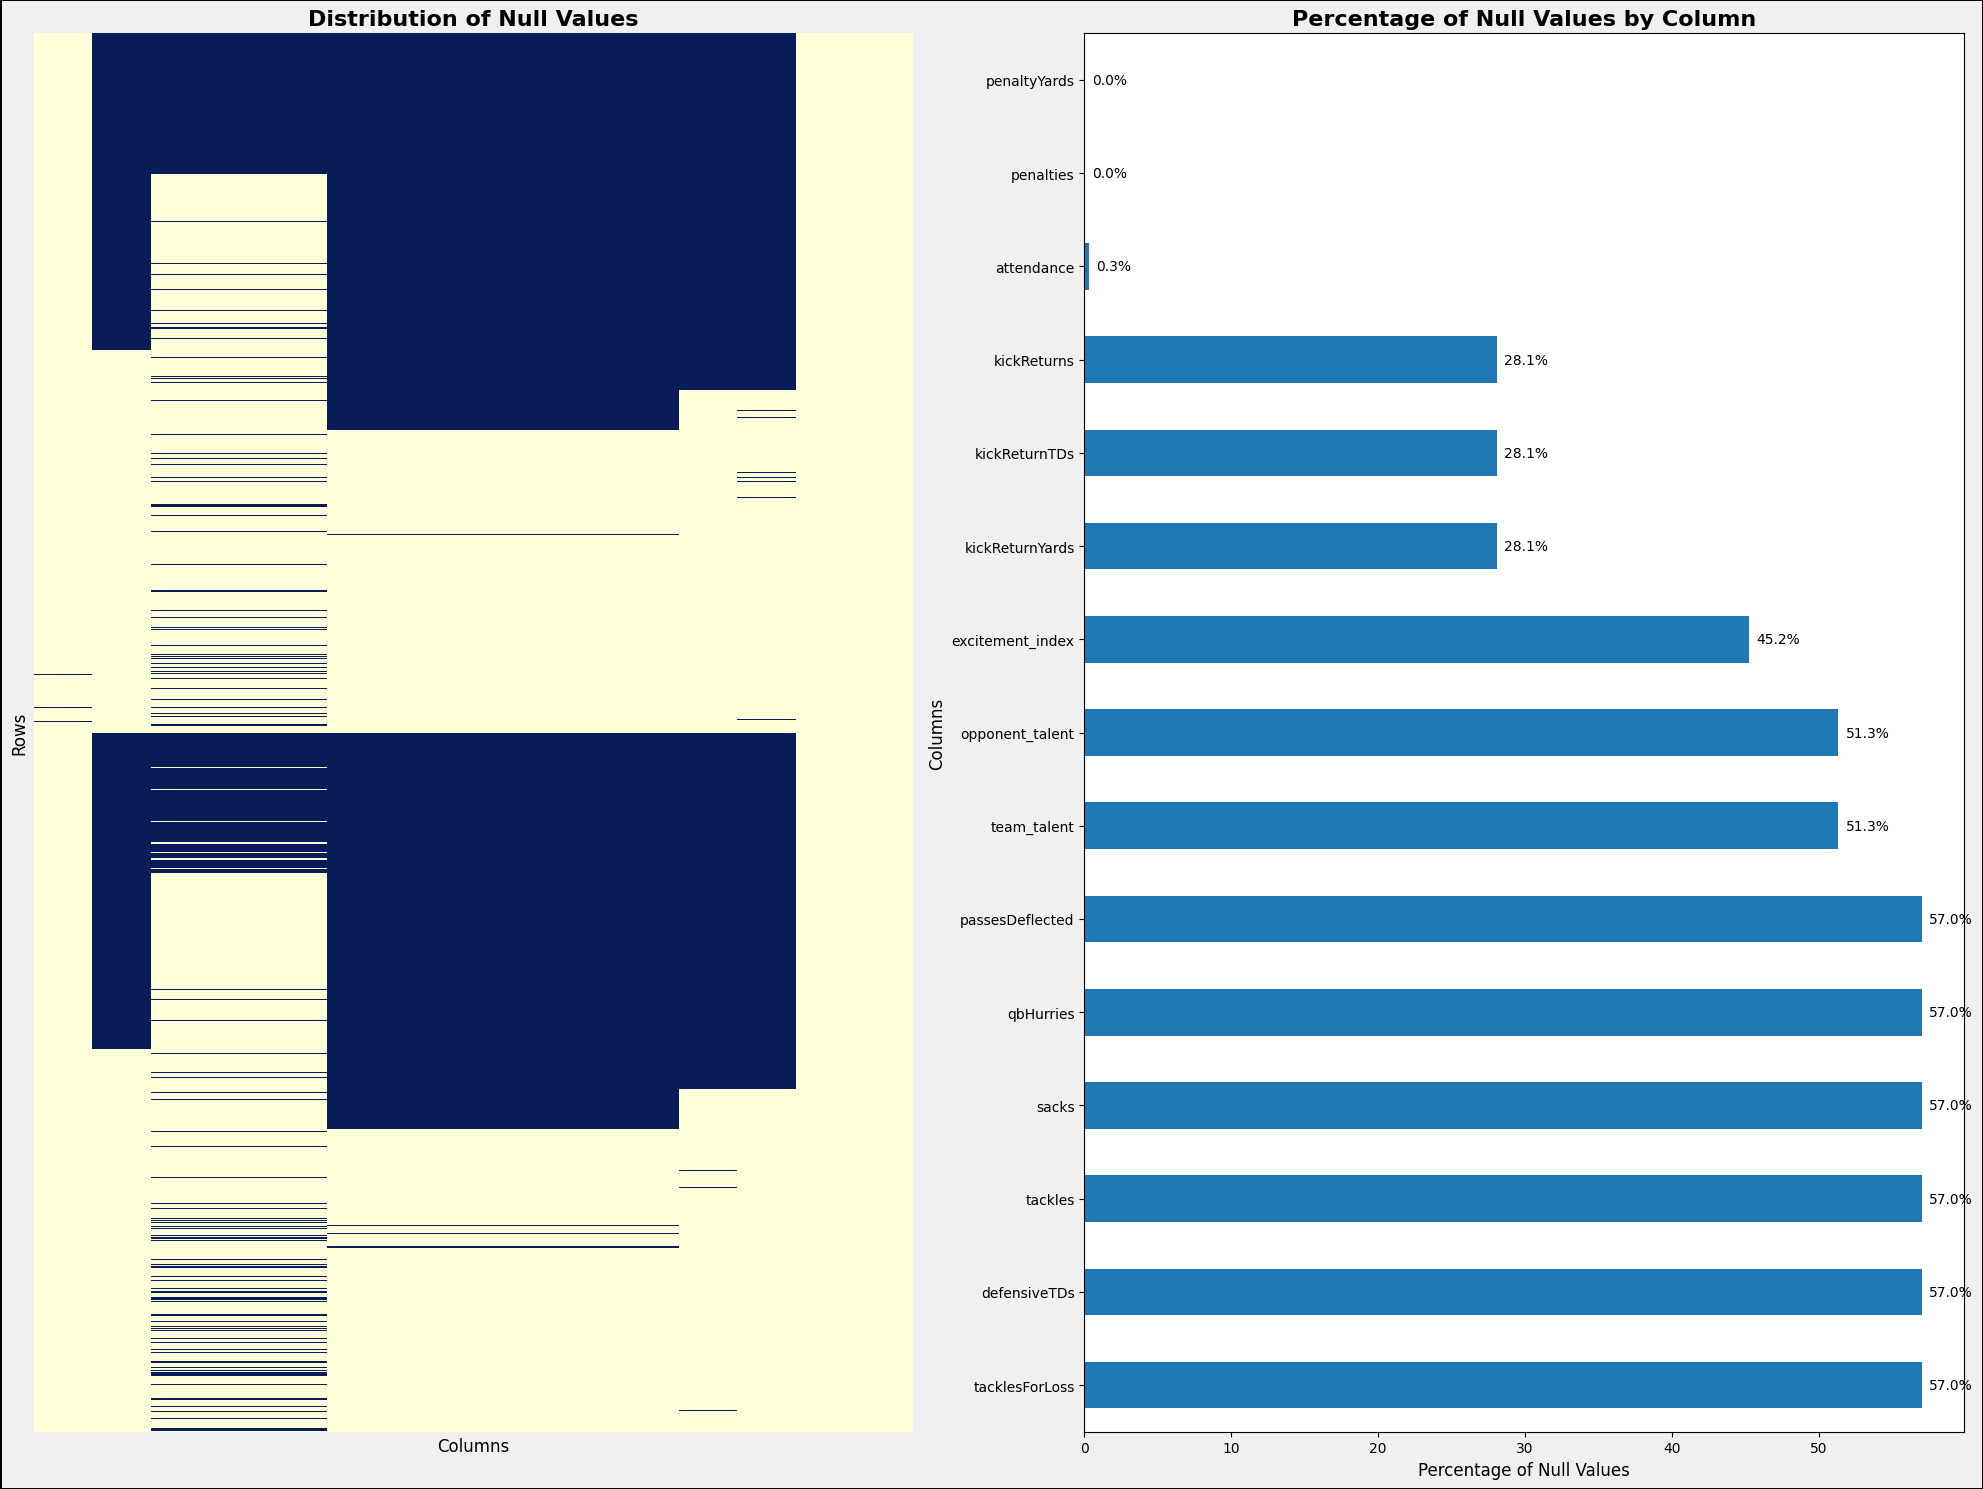

Columns with null values (sorted by percentage, descending):
tacklesForLoss: 9376 null values (57.04%)
defensiveTDs: 9376 null values (57.04%)
tackles: 9376 null values (57.04%)
sacks: 9376 null values (57.04%)
qbHurries: 9376 null values (57.04%)
passesDeflected: 9376 null values (57.04%)
team_talent: 8440 null values (51.34%)
opponent_talent: 8440 null values (51.34%)
excitement_index: 7436 null values (45.24%)
kickReturnYards: 4620 null values (28.11%)
kickReturnTDs: 4620 null values (28.11%)
kickReturns: 4620 null values (28.11%)
attendance: 54 null values (0.33%)
penalties: 1 null values (0.01%)
penaltyYards: 1 null values (0.01%)


In [170]:
visualize_null_values(cleaned_df)

## Matchup and Target Variables

In [171]:
# Create a matchup column with team_id and opponent_id (not sorted)
cleaned_df['matchup'] = cleaned_df.apply(lambda row: (row['team_id'], row['opponent_id']), axis=1)

# Display the first few rows to verify the new column
print(cleaned_df[['team_id', 'opponent_id', 'matchup']].head())

# Display value counts to check the distribution
print("\nTop 10 most common matchups:")
print(cleaned_df['matchup'].value_counts().head(10))

# Ensure 'start_date' column exists and is in the correct format
if 'start_date' not in cleaned_df.columns:
    print("Warning: 'start_date' column is missing. This is required for calculate_team_vs_team_win_rate function.")
else:
    print("'start_date' column exists. Ensure it's in the correct datetime format.")

# Check if 'win' column exists
if 'win' not in cleaned_df.columns:
    print("Warning: 'win' column is missing. This is required for calculate_team_vs_team_win_rate function.")
else:
    print("'win' column exists.")

   team_id  opponent_id      matchup
0      238         2579  (238, 2579)
1        2         2433    (2, 2433)
2       61          290    (61, 290)
3      344         2655  (344, 2655)
4       99          204    (99, 204)

Top 10 most common matchups:
matchup
(228, 59)     21
(59, 228)     21
(103, 259)    21
(201, 251)    21
(259, 103)    21
(2, 61)       21
(251, 201)    21
(61, 2)       21
(197, 239)    20
(239, 201)    20
Name: count, dtype: int64
'start_date' column exists. Ensure it's in the correct datetime format.


In [172]:
# Create a 'win' column based on the 'result' column
cleaned_df['win'] = cleaned_df['result'].where(cleaned_df['result'] == 'win', 0)
cleaned_df['win'] = cleaned_df['win'].where(cleaned_df['win'] == 0, 1)

# Convert 'win' column to integer type
cleaned_df['win'] = cleaned_df['win'].astype(int)

# Display the first few rows to verify the new column
print(cleaned_df[['result', 'win']].head())

# Display value counts to check the distribution
print("\nValue counts for 'win' column:")
print(cleaned_df['win'].value_counts(normalize=True))

  result  win
0   loss    0
1    win    1
2    win    1
3    win    1
4    win    1

Value counts for 'win' column:
win
0    0.5
1    0.5
Name: proportion, dtype: float64


## Split into All Years and All Data

In [173]:
# Split cleaned_df into two DataFrames

# DataFrame with seasons 2016 and later
df_2016_plus = cleaned_df[cleaned_df['season'] >= 2016].copy()

# DataFrame with all seasons but specific columns dropped
columns_to_drop = [
    'tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries',
    'passesDeflected', 'team_talent', 'opponent_talent', 'excitement_index',
    'kickReturnYards', 'kickReturnTDs', 'kickReturns', 'attendance'
]
df_all_years = cleaned_df.drop(columns=columns_to_drop)

# Print info about the resulting DataFrames
print("DataFrame with seasons 2016 and later:")
print(f"Shape: {df_2016_plus.shape}")
print(f"Seasons included: {df_2016_plus['season'].unique()}")
print("\nDataFrame with all seasons and specific columns dropped:")
print(f"Shape: {df_all_years.shape}")
print(f"Seasons included: {df_all_years['season'].unique()}")
print("Columns dropped:", columns_to_drop)

# Verify that the specified columns were dropped
remaining_columns = set(df_all_years.columns)
dropped_columns = set(columns_to_drop)
if not dropped_columns.issubset(cleaned_df.columns):
    print("\nWarning: Some specified columns were not in the original DataFrame.")
if dropped_columns.intersection(remaining_columns):
    print("\nWarning: Some specified columns were not dropped.")
else:
    print("\nAll specified columns were successfully dropped from df_all_years.")

DataFrame with seasons 2016 and later:
Shape: (7110, 121)
Seasons included: [2016 2017 2018 2019 2020 2021 2022 2023]

DataFrame with all seasons and specific columns dropped:
Shape: (16438, 108)
Seasons included: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]
Columns dropped: ['tacklesForLoss', 'defensiveTDs', 'tackles', 'sacks', 'qbHurries', 'passesDeflected', 'team_talent', 'opponent_talent', 'excitement_index', 'kickReturnYards', 'kickReturnTDs', 'kickReturns', 'attendance']

All specified columns were successfully dropped from df_all_years.


## Save to Parquet

In [174]:
# Save df_2016_plus and df_all_years to root/data/02_interim

# Define the path for the interim data directory
interim_data_dir = os.path.join(project_root, 'data', '02_interim')

# Ensure the directory exists
os.makedirs(interim_data_dir, exist_ok=True)

# Save df_2016_plus as a Parquet file
df_2016_plus_path = os.path.join(interim_data_dir, 'df_2016_plus.parquet')
df_2016_plus.to_parquet(df_2016_plus_path, index=False)

# Save df_all_years as a Parquet file
df_all_years_path = os.path.join(interim_data_dir, 'df_all_years.parquet')
df_all_years.to_parquet(df_all_years_path, index=False)

print(f"df_2016_plus saved to: {df_2016_plus_path}")
print(f"df_all_years saved to: {df_all_years_path}")

df_2016_plus saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/data/02_interim/df_2016_plus.parquet
df_all_years saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/data/02_interim/df_all_years.parquet


## Team Pairs

In [155]:
team_pairs_file = generate_and_save_team_pairs(cleaned_df, project_root)
print(f"Team pairs saved to: {team_pairs_file}")


Team pairs saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/src/utils/team_pairs.py
